In [98]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import collections
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

def cumsum(vector):
    cumulative = []
    sum =0
    for i in vector:
        if i == None:
            cumulative.append(None)
        else:
            sum += i
            cumulative.append(sum)
    return cumulative



def STAP(clf, controler_input, nb_mistakes, i):    

    prediction = clf(controler_input)
    initial_action = torch.round( nn.Sigmoid()(prediction) )

    r = np.random.uniform(0,1)
    flip_proba = np.sqrt( (1+nb_mistakes)/(i+1) )

    if (initial_action == 1 ) or (initial_action == 0 and r <= flip_proba):
        STAP_action = 1
    else:
        STAP_action = 0
    
    return initial_action, STAP_action

def CesaBianchi(clf, controler_input, beta, K):

    prediction = clf(controler_input)
    initial_action = torch.round( nn.Sigmoid()(prediction) )

    p = beta / ( beta + abs( prediction.item() ) )
    cesa_action = np.random.binomial(1, p)
    
    
    return initial_action, cesa_action
    

def PLOT(epsilon,):
    q = np.random.binomial(1, epsilon)


def generate_sequence(target, k, t, test_loader,n_classes,epsilon):

        R = {}
        Sa = []
        for i,data in enumerate(test_loader):
            x,y = data
            x_attacked = fgsm_attack(target, epsilon, x, y, n_classes)

            if i < t:
                v =  nn.CrossEntropyLoss()( target.clf(x_attacked) ,y)
                R[i] = v
                R = {k: v for k, v in sorted(R.items(), key=lambda item: item[1])}
            else:
                v =  nn.CrossEntropyLoss()( target.clf(x_attacked) ,y)
                last_value = list(R.values())[-1]
                last_key = list(R.keys())[-1]
                if v>=last_value and len(Sa)<=k:
                    del R[ last_key ]
                    R[i] = v
                    R = {k: v for k, v in sorted(R.items(), key=lambda item: item[1])}
                    Sa.append(i)

        attack_label = [ 1 if i in Sa else 0 for i in range(len(test_loader)) ]
                    
        return attack_label

def fgsm_attack(target, epsilon, x, y, n_classes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    
    if n_classes <=2:
        dlt =  target.clf(x)[0] - y
    else:
        label = torch.zeros(n_classes)
        label[y] = 1
        dlt =  target.clf( x ) - label

    direction = torch.sign( torch.matmul( dlt, target.clf[0].weight ) ).to(device)
    x_attacked = x + epsilon * direction
    return x_attacked

def reset(clf):
    for layer in clf.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()




In [99]:


class Target:

    def __init__(self,  n_classes, n_features, seed = 42):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        self.clf = nn.Sequential( nn.Linear(n_features, n_classes)).to(device)
        self.opt = optim.SGD( self.clf.parameters(), lr=1e-1 )

    def epoch(self, loader, model, opt=None):
        """Standard training/evaluation epoch over the dataset"""
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        total_loss, total_err = 0.,0.
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            yp = model(X)
            loss = nn.CrossEntropyLoss()(yp,y)
            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item() * X.shape[0]
        return total_err / len(loader.dataset), total_loss / len(loader.dataset)

    def train(self, loader, n_epochs=1):
        for t in range(n_epochs):
            train_err, train_loss = self.epoch(loader, self.clf, self.opt)




class Controler:

    def __init__(self,  n_classes, n_features, seed = 42):

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        self.clf = nn.Sequential( nn.Linear(n_features, 1) ).to(self.device)
        self.opt = optim.SGD( self.clf.parameters(), lr=1e-1 )
        self.X_train = torch.Tensor([]).to(self.device)
        self.y_train = torch.Tensor([]).to(self.device)

    def epoch(self, loader, model, opt=None):
        """Standard training/evaluation epoch over the dataset"""
        
        #total_loss, total_err = 0., 0.
        for X,y in loader:
            X,y = X.to(self.device), y.to(self.device)
            yp = model(X)

            loss = nn.BCELoss()(  nn.Sigmoid()(yp) ,y)

            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            #total_err += (yp.max(dim=1)[1] != y).sum().item()
            #total_loss += loss.item() * X.shape[0]
        #return total_err / len(loader.dataset), total_loss / len(loader.dataset)

    def train(self, loader, n_epochs=1):
        for _ in range(n_epochs):
            self.epoch(loader, self.clf, self.opt)

    def append(self, x, y):
        self.X_train = torch.cat( (self.X_train,x[0]) )
        self.y_train = torch.cat( ( self.y_train,  torch.Tensor([[y]]).to(self.device) ) )

    def get_loader(self, batch_size=32):
        return DataLoader(  TensorDataset( self.X_train, self.y_train  ), batch_size = batch_size, shuffle=False) 











class Task:

    def __init__(self, n, n_features, n_classes, class_sep, percent_flip, attack_proba, epsilon, seed = 42):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

        self.n_features, self.n_classes = n_features, n_classes
        X, y = make_classification(n_samples = n, n_features = n_features,  n_informative = 2, n_redundant = 1, n_classes = n_classes, flip_y = percent_flip, class_sep = class_sep, n_clusters_per_class = 1 )
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)
        train_loader = DataLoader( TensorDataset( Tensor(X_train).to(device), Tensor(y_train).type(torch.LongTensor).to(device) ) , batch_size = 32, shuffle=True)
        test_loader = DataLoader(  TensorDataset( Tensor(X_test).to(device), Tensor(y_test).type(torch.LongTensor).to(device) ), batch_size = 1, shuffle=False)

        ### Train the target classifier:
        self.target = Target(n_classes,n_features)
        self.target.train(train_loader, 10)

        #attack_label = generate_sequence(self.target, 10, 10, test_loader, n_classes, epsilon)
        attack_label = [  np.random.choice([1,0], p=[attack_proba, 1-attack_proba]) for _ in range(len(X_test)) ]
        X_test = [ fgsm_attack(self.target, epsilon, data[0], data[1], n_classes) if attack_label[i] else data[0] for i,data in enumerate(test_loader) ]

        self.test_loader = DataLoader(  TensorDataset( torch.stack( X_test ).to(device), Tensor(y_test).type(torch.LongTensor).to(device) ), batch_size = 1, shuffle=False)
        self.attack_label = torch.Tensor(attack_label).to(torch.float32)

    def online(self, method, beta=1 ):

        controler = Controler( 2, self.n_features+self.n_classes)
        regrets = []
        K, attacks,i, abs_false_pos, abs_true_pos, false_pos, true_pos,  = 0,0,0,0,0,0,0
        for i,data in enumerate(self.test_loader):

            x, y_true = data[0][0], data[1] 
            is_attacked = self.attack_label[i]

            target_pred = self.target.clf(x) 
            controler_input = torch.concat( (x, target_pred), axis = 1)

            if method == 'STAP':
                initial_action, decision = STAP(controler.clf, controler_input, K, i) 
            elif method == 'Cesa':
                initial_action, decision = CesaBianchi(controler.clf, controler_input, beta, K)


            if decision == 1:
                if is_attacked != initial_action:
                    controler.append([controler_input.detach()], is_attacked)
                    controler.clf.apply(reset)
                    controler.train(  controler.get_loader(), n_epochs=1)  
                    K = K+1  

            abs_true_pos = abs_true_pos+1 if decision == 1 and is_attacked == 1 else abs_true_pos
            abs_false_pos = abs_false_pos+1 if decision == 1 and is_attacked == 0 else abs_false_pos
            true_pos = true_pos+1 if initial_action == 1 and is_attacked == 1 else true_pos
            false_pos = false_pos+1 if initial_action == 1 and is_attacked == 0 else false_pos
            regret = abs( decision - is_attacked)

            regrets.append(regret.item())
            attacks = attacks+1 if is_attacked == 1 else attacks
            i+=1

        plt.plot( cumsum(regrets) )
        plt.xlabel('Iteration')
        plt.ylabel('Cumulative Regret')
        print('     True positive:{},      False positive:{}'.format(true_pos,false_pos,attacks))
        print('Abs. True positive:{}, Abs. False positive:{}, Attacks:{}'.format(abs_true_pos,abs_false_pos,attacks))
                
    def offline(self):

        attack_clf = SGDClassifier(loss = 'hinge')
        train_attack_label = [  np.random.choice([1,0], p=[attack_proba, 1-attack_proba]) for _ in range(len(self.X_train)) ]
        X_train_attacks = [ fgsm_attack(self.target, epsilon, [x], y, n_classes) if is_attacked else x for x,y, is_attacked in zip(self.X_train, self.y_train, train_attack_label)  ]
        X_train_attacks = np.concatenate( X_train_attacks, axis=0 )
    
        attack_clf.fit( X_train_attacks, train_attack_label ) 
        y_pred = attack_clf.predict( self.X_test )

        tn, fp, fn, tp = confusion_matrix( self.attack_label , y_pred).ravel()
        print('True positive:{}, False positive:{}, Attacks:{}'.format(tp,fp,sum(self.attack_label) ) )
        
    

Online STAP:
     True positive:402,      False positive:62
Abs. True positive:424, Abs. False positive:868, Attacks:496

Online Cesa Bianchi:
     True positive:385,      False positive:171
Abs. True positive:61, Abs. False positive:1116, Attacks:496


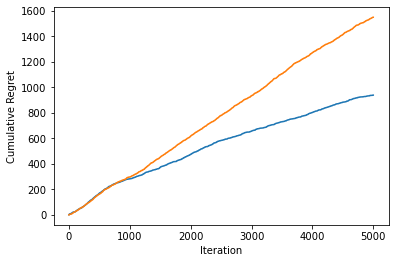

In [100]:


n = 10000
n_classes = 2
classes =  np.arange(0, n_classes)
attack_proba =  0.1
epsilon = 10
n_features = 10
class_sep = 10
percent_flip = 0.1

task = Task(n, n_features, n_classes, class_sep, percent_flip, attack_proba, epsilon)

print("Online STAP:")
task.online('STAP')
print()
print("Online Cesa Bianchi:")
task.online('Cesa', 1)
# print()
# print("Offline:")
# task.offline()